Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [1]:
# Imports libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the csv files from part 2 with Foursquare and Yelp EDA
cb = pd.read_csv('../data/cb_montreal_stations.csv')
fsq = pd.read_csv('../data/fsq_bar_features.csv')
yelp = pd.read_csv('../data/yelp_bar_features.csv')

In [3]:
fsq.sort_values(by='name')

,name,postcode,category,distance,latitude,longitude
3952,132 Bar Vintage,H3L 1T4,Cocktail Bar,123.0,45.547582,-73.665229
87,132 Bar Vintage,H3L 1T4,Cocktail Bar,810.0,45.553400,-73.662255
3651,132 Bar Vintage,H3L 1T4,Cocktail Bar,871.0,45.550692,-73.656367
3969,132 Bar Vintage,H3L 1T4,Cocktail Bar,299.0,45.544079,-73.667357
4025,3 Amigos Laval,H7T 2J2,Bar,739.0,45.551886,-73.744440
...,...,...,...,...,...,...
3245,Zoé Fondues-Karaoke,H2A 1W3,Bar,901.0,45.551585,-73.599165
3201,Zoé Fondues-Karaoke,H2A 1W3,Bar,378.0,45.557762,-73.601545
3987,À Domicile,H7T 2K9,Bar,130.0,45.568420,-73.746873
2284,À Domicile,H7T 2K9,Bar,685.0,45.570727,-73.737086


In [4]:
yelp.sort_values(by='name')

,name,postcode,category,review_count,rating,price,distance,latitude,longitude
3245,123 Dzo,H7S 1Z4,Bars,6.0,4.0,NaN,1134.200694,45.565007,-73.731905
3622,123 Dzo,H7S 1Z4,Bars,6.0,4.0,NaN,439.941107,45.570727,-73.737086
5921,123 Dzo,H7S 1Z4,Bars,6.0,4.0,NaN,536.542852,45.568420,-73.746873
4144,Abreuvoir Bar & Terrasse,H2L 1N5,Bars,25.0,4.0,$$,973.129127,45.524359,-73.560534
3456,Abreuvoir Bar & Terrasse,H2L 1N5,Bars,25.0,4.0,$$,1067.727032,45.523194,-73.555843
...,...,...,...,...,...,...,...,...,...
387,Über Cafbar,H2C 1P8,Bars,6.0,4.5,$$,619.738926,45.556751,-73.667162
102,Über Cafbar,H2C 1P8,Bars,6.0,4.5,$$,555.812130,45.553400,-73.662255
4816,Über Cafbar,H2C 1P8,Bars,6.0,4.5,$$,719.766522,45.563872,-73.655568
4879,Über Cafbar,H2C 1P8,Bars,6.0,4.5,$$,113.590897,45.557022,-73.659902


In [5]:
fsq['name'].nunique()

563

In [6]:
yelp['name'].nunique()

467

A few observations here:

* There are more unique bar names in the 'fsq' dataframe.
* The category of bars from 'fsq' is better categorized, because Foursquare already has a taxonomy of well-define category. We used search string "bars" for categories in the Yelp API call, thus it's not as well-organized.
* The 'distance' column in both Yelp has values greater than 1000m, although we set the radius=1000 only.

For the reasons above, we'll use bar information from Foursquare as the base of our clean data; then add additional information such as 'review_count', 'rating', 'price' from Yelp.

In [7]:
# Merge to add 'review_count', 'rating', 'price' columns from the 'yelp' to 'fsq' dataframe
fsq = fsq.merge(yelp[['name', 'review_count', 'rating', 'price']].drop_duplicates(subset=['name']), on='name', how='left')

In [8]:
# Check again the new 'fsq' dataframe after adding 'review_count', 'rating', 'price' from Yelp
fsq

,name,postcode,category,distance,latitude,longitude,review_count,rating,price
0,Resto-bar Capucine - Nord-Est de Montréal,NaN,Sports Bar,246.0,45.617500,-73.606011,NaN,NaN,NaN
1,Piano Bar la Belle Epoque,H1G 2V6,Cocktail Bar,661.0,45.617500,-73.606011,NaN,NaN,NaN
2,Cafe liana bar & grill,H1E 1M4,Bar,809.0,45.617500,-73.606011,NaN,NaN,NaN
3,La Veranda,H1G 2V5,Bar,960.0,45.617500,-73.606011,NaN,NaN,NaN
4,Le Saint Bock,H2X 3K4,Bar,132.0,45.516926,-73.564257,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5892,Brasserie Dieu du Ciel,H2T 2N2,Beer Bar,815.0,45.523877,-73.583049,NaN,NaN,NaN
5893,Pub Pit Caribou,H2J 2J4,Beer Bar,608.0,45.523877,-73.583049,NaN,NaN,NaN
5894,Kabinet,H2T 2N4,Bar,852.0,45.523877,-73.583049,NaN,NaN,NaN
5895,Buvette Chez Simone,H2V 4E7,Wine Bar,1002.0,45.523877,-73.583049,117.0,4.5,$$


Now, we just need to merge the new 'fsq' with the Citybikes data in the 'cb' dataframe.

In [9]:
# Merge 'cb' and 'fsq' based on 'cb_latitude' and 'cb_longitude' in 'cb' and 'latitude' and 'longitude' in 'fsq'
merged_all_df = pd.merge(cb, fsq, left_on=['cb_latitude', 'cb_longitude'], right_on=['latitude', 'longitude'], how='inner')

# Drop the repeated 'latitude' and 'longitude' columns from the merged DataFrame
merged_all_df = merged_all_df.drop(['latitude', 'longitude'], axis=1)

merged_all_df

,cb_station_id,cb_station_name,cb_latitude,cb_longitude,cb_bike_num,name,postcode,category,distance,review_count,rating,price
0,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,6,Resto-bar Capucine - Nord-Est de Montréal,NaN,Sports Bar,246.0,NaN,NaN,NaN
1,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,6,Piano Bar la Belle Epoque,H1G 2V6,Cocktail Bar,661.0,NaN,NaN,NaN
2,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,6,Cafe liana bar & grill,H1E 1M4,Bar,809.0,NaN,NaN,NaN
3,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,6,La Veranda,H1G 2V5,Bar,960.0,NaN,NaN,NaN
4,36c6491aa1b52e5ef7005f984738de27,Gare d'autocars de Montréal (Berri / Ontario),45.516926,-73.564257,1,Le Saint Bock,H2X 3K4,Bar,132.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5892,dd8b2e953a8fe66b74e945dee00a2793,Mont-Royal / St-Denis,45.523877,-73.583049,6,Brasserie Dieu du Ciel,H2T 2N2,Beer Bar,815.0,NaN,NaN,NaN
5893,dd8b2e953a8fe66b74e945dee00a2793,Mont-Royal / St-Denis,45.523877,-73.583049,6,Pub Pit Caribou,H2J 2J4,Beer Bar,608.0,NaN,NaN,NaN
5894,dd8b2e953a8fe66b74e945dee00a2793,Mont-Royal / St-Denis,45.523877,-73.583049,6,Kabinet,H2T 2N4,Bar,852.0,NaN,NaN,NaN
5895,dd8b2e953a8fe66b74e945dee00a2793,Mont-Royal / St-Denis,45.523877,-73.583049,6,Buvette Chez Simone,H2V 4E7,Wine Bar,1002.0,117.0,4.5,$$


In [10]:
merged_all_df.shape

(5897, 12)

In [11]:
# Save our master dataframe 'merged_all_df' results to csv
merged_all_df.to_csv('../data/merged_all_df.csv', index=False)

### Exploring the data

In [12]:
merged_all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5897 entries, 0 to 5896
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cb_station_id    5897 non-null   object 
 1   cb_station_name  5897 non-null   object 
 2   cb_latitude      5897 non-null   float64
 3   cb_longitude     5897 non-null   float64
 4   cb_bike_num      5897 non-null   int64  
 5   name             5897 non-null   object 
 6   postcode         5716 non-null   object 
 7   category         5897 non-null   object 
 8   distance         5897 non-null   float64
 9   review_count     1753 non-null   float64
 10  rating           1753 non-null   float64
 11  price            1522 non-null   object 
dtypes: float64(5), int64(1), object(6)
memory usage: 598.9+ KB


Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

In [13]:
merged_all_df.describe()

,cb_latitude,cb_longitude,cb_bike_num,distance,review_count,rating
count,5897.000000,5897.000000,5897.000000,5897.000000,1753.000000,1753.000000
mean,45.521258,-73.587396,7.966593,585.347974,75.695379,3.895893
std,0.030836,0.034029,8.111172,255.671371,72.575497,0.512821
min,45.417746,-73.758227,0.000000,5.000000,1.000000,2.000000
25%,45.501863,-73.603635,2.000000,385.000000,20.000000,3.500000
50%,45.523615,-73.579389,5.000000,599.000000,44.000000,4.000000
75%,45.539385,-73.566583,11.000000,801.000000,121.000000,4.000000
max,45.702349,-73.436058,51.000000,1151.000000,388.000000,5.000000


In [14]:
# Add a new column 'unique_name_count' to store the count of unique bars per citybike station in Montreal
merged_all_df['cb_name_count'] = merged_all_df.groupby('cb_station_name')['name'].transform('nunique')

In [15]:
merged_all_df.head()

,cb_station_id,cb_station_name,cb_latitude,cb_longitude,cb_bike_num,name,postcode,category,distance,review_count,rating,price,cb_name_count
0,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,6,Resto-bar Capucine - Nord-Est de Montréal,NaN,Sports Bar,246.0,NaN,NaN,NaN,4
1,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,6,Piano Bar la Belle Epoque,H1G 2V6,Cocktail Bar,661.0,NaN,NaN,NaN,4
2,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,6,Cafe liana bar & grill,H1E 1M4,Bar,809.0,NaN,NaN,NaN,4
3,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,6,La Veranda,H1G 2V5,Bar,960.0,NaN,NaN,NaN,4
4,36c6491aa1b52e5ef7005f984738de27,Gare d'autocars de Montréal (Berri / Ontario),45.516926,-73.564257,1,Le Saint Bock,H2X 3K4,Bar,132.0,NaN,NaN,NaN,10


In [16]:
# Check where the missing values are located
merged_all_df.isnull().sum()

cb_station_id         0
cb_station_name       0
cb_latitude           0
cb_longitude          0
cb_bike_num           0
name                  0
postcode            181
category              0
distance              0
review_count       4144
rating             4144
price              4375
cb_name_count         0
dtype: int64

* Treat missing values in 'postcode':

In [17]:
yelp[['name','postcode']].drop_duplicates()

,name,postcode
0,Les Deux Gamins,H2X 1B7
1,Le 4e Mur,H2X 3K8
2,Randolph Pub Ludique,H2X 3K8
3,Les 3 Brasseurs,H2X 3K6
4,Cadet,H2X 2S8
...,...,...
7219,No 900,J6W 1E6
7220,La Confrérie,J6W 1E3
7221,La Buvette du Vieux-Terrebonne,J6W 1J9
8033,Peroni Resto Bar,H3B


In [18]:
# Create a mapping of 'name' to 'postcode' from the Yelp dataframe above. It has a bigger dataset than Foursquare
unique_yelp_postcode_mapping = yelp[['name', 'postcode']].drop_duplicates().set_index('name')['postcode'].to_dict()

# Use the mapping to fill missing 'postcode' values in merged_all_df
merged_all_df['postcode'].fillna(merged_all_df['name'].map(unique_yelp_postcode_mapping), inplace=True)

In [19]:
merged_all_df['postcode'].isnull().sum()

176

In [20]:
# Fill the rest of 176 missing values in 'postcode' with 'Postcode Unavailable'
merged_all_df['postcode'].fillna('Unavailable', inplace=True)

* Treat missing values in 'review_count', 'rating':

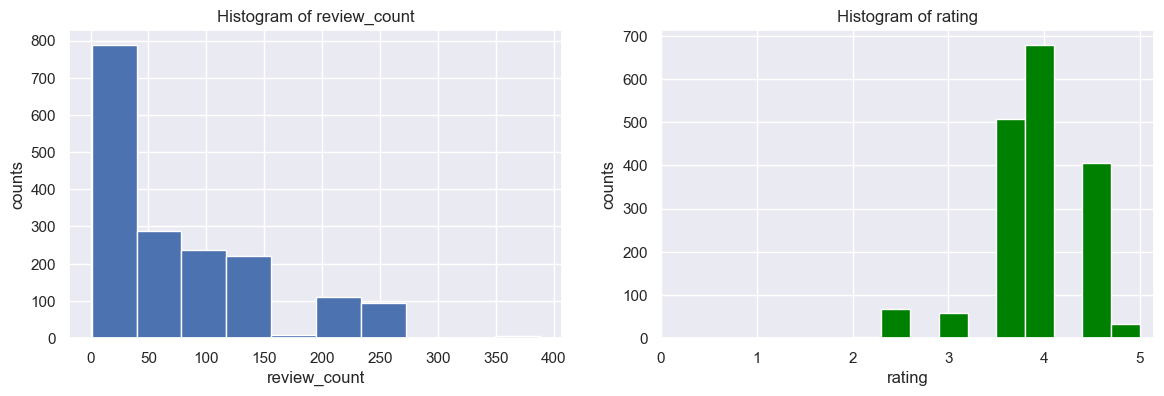

In [21]:
# Create 2 graphs to visualize the distribution of  'review_count' and 'rating':
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Plot 0
axes[0].hist(merged_all_df['review_count'])
axes[0].set_title('Histogram of review_count')
axes[0].set_xlabel('review_count')
axes[0].set_ylabel('counts')

# Plot 1
axes[1].hist(merged_all_df['rating'], color='green')
axes[1].set_title('Histogram of rating')
axes[1].set_xlabel('rating')
axes[1].set_ylabel('counts')
axes[1].set_xlim(left=0)

plt.show()

In [22]:
# As the distributions of these two columns are skewed, we will fill in the missing values with the median.
merged_all_df['review_count'].fillna(merged_all_df['review_count'].median(), inplace=True)
merged_all_df['rating'].fillna(merged_all_df['rating'].median(), inplace=True)

* Treat missing values in 'price':

In [23]:
merged_all_df['price'].value_counts()

$$     1244
$$$     176
$       102
Name: price, dtype: int64

In [24]:
# Calculate the percentage of each price category
(merged_all_df['price'].value_counts() / merged_all_df['price'].notnull().sum()) * 100

$$     81.734560
$$$    11.563732
$       6.701708
Name: price, dtype: float64

In [25]:
# The '$$' value is most populated with > 80%, we'll use it to fill in missing values in this column
merged_all_df['price'].fillna('$$', inplace=True)

According to this paper at: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0252157#:~:text=Yelp%20use%20dollar%20signs%20(%24),higher%20level%20means%20more%20expensive

"Yelp uses dollar signs to categorize approximate cost per person for a meal in a restaurant. In particular, one dollar sign means under 10 dollars; two dollar signs means from 11 to 30 dollars; three dollar signa means from 31 to 60 dollars; and four dollar signs means above 61 dollars.

We can reassign the funky dollar sign values in 'price' column into a categorical system that takes 1 to 4 as price levels. Higher level means more expensive.

In [26]:
def assign_price_level(price):
    if price == '$':
        return 1
    elif price == '$$':
        return 2
    elif price == '$$$':
        return 3
    else:
        return 4
    
merged_all_df['price_level'] = merged_all_df['price'].apply(assign_price_level)

In [27]:
# Drop 'price' as we already indicated the same thing in 'price_level'
merged_all_df = merged_all_df.drop('price', axis=1)

In [28]:
merged_all_df

,cb_station_id,cb_station_name,cb_latitude,cb_longitude,cb_bike_num,name,postcode,category,distance,review_count,rating,cb_name_count,price_level
0,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,6,Resto-bar Capucine - Nord-Est de Montréal,Unavailable,Sports Bar,246.0,44.0,4.0,4,2
1,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,6,Piano Bar la Belle Epoque,H1G 2V6,Cocktail Bar,661.0,44.0,4.0,4,2
2,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,6,Cafe liana bar & grill,H1E 1M4,Bar,809.0,44.0,4.0,4,2
3,72bfd647b3d2b650546f42319729757d,Cégep Marie-Victorin,45.617500,-73.606011,6,La Veranda,H1G 2V5,Bar,960.0,44.0,4.0,4,2
4,36c6491aa1b52e5ef7005f984738de27,Gare d'autocars de Montréal (Berri / Ontario),45.516926,-73.564257,1,Le Saint Bock,H2X 3K4,Bar,132.0,44.0,4.0,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5892,dd8b2e953a8fe66b74e945dee00a2793,Mont-Royal / St-Denis,45.523877,-73.583049,6,Brasserie Dieu du Ciel,H2T 2N2,Beer Bar,815.0,44.0,4.0,10,2
5893,dd8b2e953a8fe66b74e945dee00a2793,Mont-Royal / St-Denis,45.523877,-73.583049,6,Pub Pit Caribou,H2J 2J4,Beer Bar,608.0,44.0,4.0,10,2
5894,dd8b2e953a8fe66b74e945dee00a2793,Mont-Royal / St-Denis,45.523877,-73.583049,6,Kabinet,H2T 2N4,Bar,852.0,44.0,4.0,10,2
5895,dd8b2e953a8fe66b74e945dee00a2793,Mont-Royal / St-Denis,45.523877,-73.583049,6,Buvette Chez Simone,H2V 4E7,Wine Bar,1002.0,117.0,4.5,10,2


In [29]:
# Final check for missing values
merged_all_df.isnull().sum()

cb_station_id      0
cb_station_name    0
cb_latitude        0
cb_longitude       0
cb_bike_num        0
name               0
postcode           0
category           0
distance           0
review_count       0
rating             0
cb_name_count      0
price_level        0
dtype: int64

In [30]:
merged_all_df.shape

(5897, 13)

In [31]:
# Drop duplicates (if any) after treating n/a, but there aren't any because cb_station_id is already unique in our dataset
merged_all_df.drop_duplicates(inplace=True)

### Visualizing the data

In [32]:
merged_all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5897 entries, 0 to 5896
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cb_station_id    5897 non-null   object 
 1   cb_station_name  5897 non-null   object 
 2   cb_latitude      5897 non-null   float64
 3   cb_longitude     5897 non-null   float64
 4   cb_bike_num      5897 non-null   int64  
 5   name             5897 non-null   object 
 6   postcode         5897 non-null   object 
 7   category         5897 non-null   object 
 8   distance         5897 non-null   float64
 9   review_count     5897 non-null   float64
 10  rating           5897 non-null   float64
 11  cb_name_count    5897 non-null   int64  
 12  price_level      5897 non-null   int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 645.0+ KB


* Exploring numeric columns:

In [33]:
numeric_cols = merged_all_df.select_dtypes(include=['number']).columns
numeric_cols

Index(['cb_latitude', 'cb_longitude', 'cb_bike_num', 'distance',
       'review_count', 'rating', 'cb_name_count', 'price_level'],
      dtype='object')

In [34]:
numeric_merge_df = merged_all_df[numeric_cols]
numeric_merge_df

,cb_latitude,cb_longitude,cb_bike_num,distance,review_count,rating,cb_name_count,price_level
0,45.617500,-73.606011,6,246.0,44.0,4.0,4,2
1,45.617500,-73.606011,6,661.0,44.0,4.0,4,2
2,45.617500,-73.606011,6,809.0,44.0,4.0,4,2
3,45.617500,-73.606011,6,960.0,44.0,4.0,4,2
4,45.516926,-73.564257,1,132.0,44.0,4.0,10,2
...,...,...,...,...,...,...,...,...
5892,45.523877,-73.583049,6,815.0,44.0,4.0,10,2
5893,45.523877,-73.583049,6,608.0,44.0,4.0,10,2
5894,45.523877,-73.583049,6,852.0,44.0,4.0,10,2
5895,45.523877,-73.583049,6,1002.0,117.0,4.5,10,2


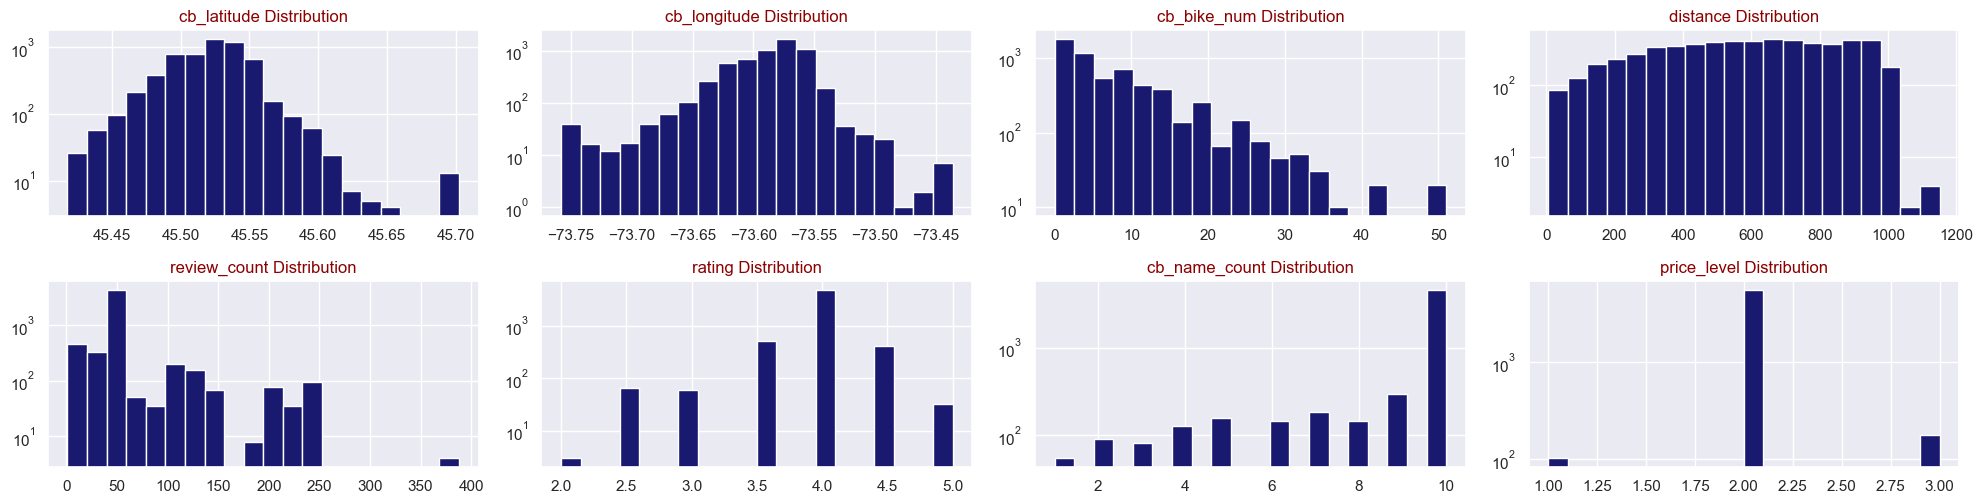

In [35]:
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows, cols, i+1)
        dataframe[feature].hist(bins=20, ax=ax, facecolor='Midnightblue')
        ax.set_title(feature + " Distribution",color='DarkRed')
        ax.set_yscale('log')
    fig.tight_layout()  
    plt.show()
    
draw_histograms(numeric_merge_df,numeric_merge_df.columns,8,4)

There are still bar locations that are further out than 1Km from Montreal bike stations. The distribution of 'cb_bike_num' is skewed right with outliers.

As per characteristic of bars (of numeric type except for 'price_level'): 'distance' looks somewhat like a uniform distribution. The distribution of 'review_count' looks skewed, 'rating' distribution is slightly skewed but can be close somewhat close a normal distribution. 

We are dealing with outliers, and we can also test the normal distribution of some of those numeric columns.

In [36]:
# Enforce the condition 'distance'values must be <= 1000 from the bike stations
merged_all_df = merged_all_df[merged_all_df['distance'] <= 1000]

* Treating outliers: We won't take into accounts outliers in 'cb_latitude' and 'cb_longitude' since we want to include all bike stations in Montreal.

In [37]:
# Percentage of rows with outliers where 'cb_bike_num' >40
len(merged_all_df[merged_all_df['cb_bike_num'] <= 40])/len(merged_all_df)

0.9931623931623932

In [38]:
# Percentage of rows with outliers where 'review_count' >300
len(merged_all_df[merged_all_df['review_count'] <= 300])/len(merged_all_df)

0.9993162393162394

We'll lose around 1% of our data (~60 rows) for each outlier removal which is quite ok.

In [39]:
# Remove extreme outliers where 'cb_bike_num' >50
merged_all_df = merged_all_df[merged_all_df['cb_bike_num'] <= 50]

In [40]:
# Remove extreme outliers where 'review_count' >300
merged_all_df = merged_all_df[merged_all_df['review_count'] <= 300]

In [41]:
merged_all_df.shape

(5836, 13)

In [42]:
merged_all_df_clean = merged_all_df.copy()

# Save the clean merged_all_df after EDA results to csv for part 4
merged_all_df_clean.to_csv('../data/merged_all_df_clean.csv', index=False)

* Perform Shapiro-Wilk's normality test on 'cb_bike_num', 'cb_name_count', 'distance', 'review_count', 'rating':
- H<sub>0</sub>: data is normally distributed
- H<sub>a</sub>: data is not normally distributed


In [43]:
stat, p = stats.shapiro(merged_all_df['cb_bike_num'])
print(p)

0.0


In [44]:
stat, p = stats.shapiro(merged_all_df['cb_name_count'])
print(p)

0.0


In [45]:
stat, p = stats.shapiro(merged_all_df['distance'])
print(p)

3.6593118478111175e-34


In [46]:
stat, p = stats.shapiro(merged_all_df['review_count'])
print(p)

0.0


In [47]:
stat, p = stats.shapiro(merged_all_df['rating'])
print(p)

0.0


Since all the p<<0.05, we reject the null hypothesis that the data in these columns are normally distributed.

* Exploring categorical columns:

Which station has the most bars close by?

In [48]:
merged_all_df['cb_station_id'].nunique()

748

In [49]:
merged_all_df['cb_station_name'].nunique()

748

In [50]:
stations_barnum_sorted = merged_all_df.groupby(['cb_station_id', 'cb_station_name'])['cb_name_count'].mean().sort_values(ascending=False).reset_index()
stations_barnum_sorted

,cb_station_id,cb_station_name,cb_name_count
0,00c210cb99cf9d1b923c1548938aee56,Marché Jean-Talon (Casgrain / Shamrock),10.0
1,9af471a77a41e1bdde69ab0533d721ec,6e Avenue / Bélanger,10.0
2,975a36ecbf71ebb1bb1cb5f5ae237f84,Lacombe / Victoria,10.0
3,97a7209d05565c0dd383256371451ed2,Hutchison / Beaubien,10.0
4,9836aac1ee4659e9103ab4a3ac10c9e0,Métro Parc (Hutchison / Ogilvy),10.0
...,...,...,...
743,8326ad85524fa7fa9e741b0cc595d098,Square Nelligan (des Appalaches / Alexis-Nihon),1.0
744,f3e8bbaffc3930bc19681467b42595cf,Beurling / Godin,1.0
745,832860f26bd8716c883200eb861e3ab7,de Mortagne / de Montarville,1.0
746,f59884dc043cf535875c6042eb59dd39,De Callières / d'Auvergne,1.0


In [51]:
# The majority of numbar of bars associated per station is 10 bars on average
stations_barnum_sorted['cb_name_count'].describe()

count    748.000000
mean       7.842246
std        3.202531
min        1.000000
25%        5.000000
50%       10.000000
75%       10.000000
max       10.000000
Name: cb_name_count, dtype: float64

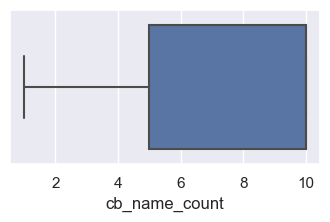

In [52]:
fig=plt.figure(figsize=(4,2))
sns.boxplot(x=stations_barnum_sorted['cb_name_count'])
plt.show()

In [53]:
# The top stations with the most number of bars will be mostly those with 10 bars nearby
top_barnum_stations = stations_barnum_sorted[stations_barnum_sorted['cb_name_count']==10]
top_barnum_stations

,cb_station_id,cb_station_name,cb_name_count
0,00c210cb99cf9d1b923c1548938aee56,Marché Jean-Talon (Casgrain / Shamrock),10.0
1,9af471a77a41e1bdde69ab0533d721ec,6e Avenue / Bélanger,10.0
2,975a36ecbf71ebb1bb1cb5f5ae237f84,Lacombe / Victoria,10.0
3,97a7209d05565c0dd383256371451ed2,Hutchison / Beaubien,10.0
4,9836aac1ee4659e9103ab4a3ac10c9e0,Métro Parc (Hutchison / Ogilvy),10.0
...,...,...,...
456,115474ece7fe0aa5e0a79e56b11b3c8c,St-André / Cherrier,10.0
457,4c87345d7a652a966f526460dfa264c5,Marché Atwater,10.0
458,4c6ee625de158c398332f0bce7a5ee9f,Henri-Julien / du Carmel,10.0
459,12d398be5955fed8787b107d04ba8cab,CÉGEP du Vieux-Montréal (Ontario / de l'Hôtel-...,10.0


Is there any relationship between the bike station name and the bar postcode and categories?

In [54]:
stations_postcode = merged_all_df[['cb_station_name','postcode']].drop_duplicates()
stations_postcode

,cb_station_name,postcode
0,Cégep Marie-Victorin,Unavailable
1,Cégep Marie-Victorin,H1G 2V6
2,Cégep Marie-Victorin,H1E 1M4
3,Cégep Marie-Victorin,H1G 2V5
4,Gare d'autocars de Montréal (Berri / Ontario),H2X 3K4
...,...,...
5891,Mont-Royal / St-Denis,H2J 1W6
5892,Mont-Royal / St-Denis,H2T 2N2
5893,Mont-Royal / St-Denis,H2J 2J4
5894,Mont-Royal / St-Denis,H2T 2N4


In [55]:
# Try to get only the 3 prefix letter to further investigate but it won't work because of too many combination
stations_postcode['postcode_prefix'] = stations_postcode['postcode'].str[:3]
stations_postcode = stations_postcode[stations_postcode['postcode_prefix'] != 'Una'].drop('postcode', axis=1).drop_duplicates()
stations_postcode

,cb_station_name,postcode_prefix
1,Cégep Marie-Victorin,H1G
2,Cégep Marie-Victorin,H1E
4,Gare d'autocars de Montréal (Berri / Ontario),H2X
12,Gare d'autocars de Montréal (Berri / Ontario),H2L
15,Centre des loisirs (Tassé / Grenet),H4L
...,...,...
5877,de la Petrie /de la Cote-des-Neiges,H3T
5883,de la Petrie /de la Cote-des-Neiges,H3S
5887,Mont-Royal / St-Denis,H2T
5888,Mont-Royal / St-Denis,H2W


It's unclear if there's any relationship between the bike station name and the bar postcode and categories at this point, because of the large number of unique combinations of the bike station names and postcode. We attempted to trial getting the first 3 letters prefix to but it still gets complicated with too many combinations. Visualization won't be the best option to carry out EDA for our categorical columns overall. To keep things simpler, it's better to just use numerical columns for prediction in our model in part 4, and not going forward with encoding categorical data.

Recall in the previous section of data visualization, all of our numeric columns have p value = 0 or very small in the normality test. However, we won't apply data transformation to convert those numeric columns into normal distribution within our scope.

* Correlation matrix:

In [56]:
merged_all_df.corr()

,cb_latitude,cb_longitude,cb_bike_num,distance,review_count,rating,cb_name_count,price_level
cb_latitude,1.000000,-0.026319,-0.142015,0.071127,-0.154397,-0.037843,-0.125630,-0.082863
cb_longitude,-0.026319,1.000000,0.051601,-0.083708,0.124968,-0.025746,0.251682,0.053754
cb_bike_num,-0.142015,0.051601,1.000000,-0.097237,0.246911,-0.004648,0.009653,0.076519
distance,0.071127,-0.083708,-0.097237,1.000000,-0.053886,0.031658,-0.112360,0.000500
review_count,-0.154397,0.124968,0.246911,-0.053886,1.000000,0.252794,0.087578,0.266044
rating,-0.037843,-0.025746,-0.004648,0.031658,0.252794,1.000000,0.004268,0.118696
cb_name_count,-0.125630,0.251682,0.009653,-0.112360,0.087578,0.004268,1.000000,0.033700
price_level,-0.082863,0.053754,0.076519,0.000500,0.266044,0.118696,0.033700,1.000000


<Axes: >

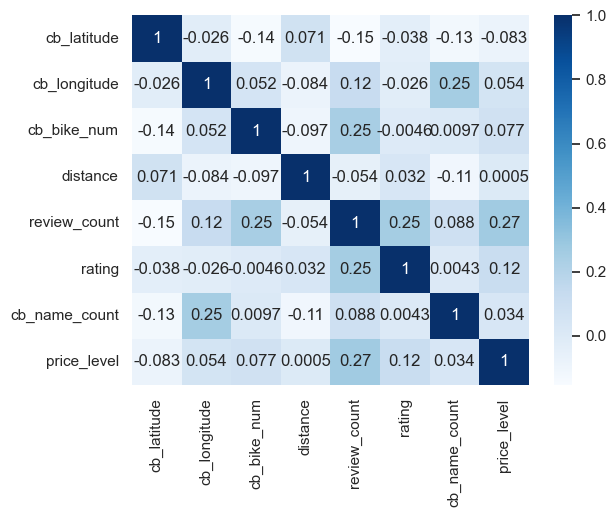

In [57]:
sns.heatmap(merged_all_df.corr(), annot = True, cmap="Blues")

From this plot we can see that it seems like there may be a very small linear correlation between our target variable ('cb_bike_num') mentioned in part 4 and these bar characteristics:

* Minor positive correlation with 'review_count' (0.25), 'price_level' (0.077)
* Minor negative correlation with 'distance'(-0.097), 'rating' (-0.0046)

A correlation near zero indicates the variables are not linearly related. Usually, the closer the number is to 1 (or -1), the stronger the correlationn. We choose to exclude the variables with very, very small near zero correlation like 'rating', and somewhat 'price_level' (It's a encoded catgegorical one anyway). We keep 'distance' has a negative number close to -0.1 which is higher than than 'price_level' and 'rating'. Thus, the dependent variables kept in our model to predict our our target variable ('cb_bike_num') are 'review_count', 'distance'.

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

Our scope for this SQLite3 database in Python for part 3:

* Create connection and access data from three API results (dataframes) that we have from part 2 into 3 tables
* Use SQL queries to access data from those 3 tables
* Join data from three multiple tables

In [58]:
# Import libraries and modules
import sqlite3
from sqlite3 import Error

* Create connection and access data from three API results (dataframes) that we have from part 2 into 3 tables

In [59]:

def create_connection(path):
    """ Create a database connection to a SQLite database """
    connection = None
    try:
        connection = sqlite3.connect(path)
        print('Connection to SQLite DB successful')
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

In [60]:
# Create an empty database named 'merged_all_sql.db' in '../data/' if not exists
connection = create_connection('../data/merged_all_sql.db')

Connection to SQLite DB successful


In [61]:
# Create a new set of dataframes again for citybikes foursquare and yelp data
cb_sql_df = pd.read_csv('../data/cb_montreal_stations.csv')
fsq_sql_df = pd.read_csv('../data/fsq_bar_features.csv')
yelp_sql_df = pd.read_csv('../data/yelp_bar_features.csv')

In [62]:
# Write DataFrame to SQLite tables: 'citybikes', 'foursquare', 'yelp' without index
cb_sql_df.to_sql('citybikes', connection, if_exists='replace', index='False')
fsq_sql_df.to_sql('foursquare', connection, if_exists='replace', index='False')
yelp_sql_df.to_sql('yelp', connection, if_exists='replace', index='False')

9061

* Use SQL queries to access data from those 3 tables

Look at the data before and after the join to validate your data.

In [63]:
# Create a function execute_read_query()
def execute_read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as e:
        print(f"The error '{e}' occurred")

In [64]:
# Query data from the 'citybikes' table
select_citybikes = "SELECT * from citybikes"
cb_rows = execute_read_query(connection, select_citybikes)

# Print one sample of the 'citybikes' table
for cb_row in cb_rows:
    print(cb_row)
    break

(0, '72bfd647b3d2b650546f42319729757d', 'Cégep Marie-Victorin', 45.61749978312808, -73.60601127147675, 6)


In [65]:
# Query data from the 'foursquare' table
select_foursquare = "SELECT * from foursquare"
fsq_rows = execute_read_query(connection, select_foursquare)

# Print one sample of the 'foursquare' table
for fsq_row in fsq_rows:
    print(fsq_row)
    break

(0, 'Resto-bar Capucine - Nord-Est de Montréal', None, 'Sports Bar', 246.0, 45.61749978312808, -73.60601127147675)


In [66]:
# Query data from the 'yelp' table
select_yelp = "SELECT * from yelp"
yelp_rows = execute_read_query(connection, select_yelp)

# Print one sample of the 'yelp' table
for yelp_row in yelp_rows:
    print(yelp_row)
    break

(0, 'Les Deux Gamins', 'H2X 1B7', 'Wine Bars', 595.0, 4.0, '$$', 546.8489417889465, 45.516926210319546, -73.56425732374191)


* Join data from three multiple tables into a database

In [67]:
# Apply the same concept as in the pandas joining tables
# Add 'review_count', 'rating', 'price' columns from the 'yelp' to 'fsq' dataframe

left_join_foursquare_yelp = '''
CREATE VIEW left_join_foursquare_yelp
AS 
SELECT foursquare.*
FROM foursquare
LEFT JOIN (
    SELECT DISTINCT name, review_count, rating, price
    FROM yelp
) As tbl ON foursquare.name = tbl.name;
'''

fsq_yelp_rows = execute_read_query(connection, left_join_foursquare_yelp)

In [68]:
# Create a view that combines the 'left_join_foursquare_yelp' view and 'citybikes' table

foursquare_yelp_citybikes = '''
CREATE VIEW merge_foursquare_yelp_citybikes
AS 
SELECT *
FROM left_join_foursquare_yelp
INNER JOIN citybikes AS cb
ON cb.cb_latitude = left_join_foursquare_yelp.latitude
AND cb.cb_longitude = left_join_foursquare_yelp.longitude;
'''

foursquare_yelp_citybikes = execute_read_query(connection, foursquare_yelp_citybikes)

The joined database is saved now as a view named 'foursquare_yelp_citybikes' in the 'merged_all_sql.db' database.